In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
import mne
from nice.algorithms.connectivity import epochs_compute_wsmi
from scipy.stats import zscore
from scipy.signal import detrend
import copy
np.set_printoptions(threshold=100)  # Default threshold
mne.set_log_level('WARNING')
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

# def preprocess(data):
#     data = detrend(data, axis=0)
#     epsilon = 1e-9
#     data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
#     return data

def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds > 1e-6
    if len(non_constant_cols) != 0:
        print('non constant column at ', np.where(non_constant_cols == False))
              
   
    constant_cols = stds < 1e-6

    z = np.zeros_like(data[:, :])
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)
    z[:, constant_cols] = np.mean(data[:, constant_cols], axis = 0)

    #unsure what to replace lost values with, for now replacing with 0

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

#making the data structures to store 
run_time = time.time()
file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

classes_left = np.arange(0, 20)
classes_right = np.arange(0, 20)

agg_structure = {f'dataset_{file_number}': 
                 {f'left_class_{class_left}': 
                  {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}

left_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
right_input_LFP_attleft_agg = copy.deepcopy(agg_structure)
attention_LFP_attleft_agg = copy.deepcopy(agg_structure)

left_input_LFP_attright_agg = copy.deepcopy(agg_structure)
right_input_LFP_attright_agg = copy.deepcopy(agg_structure)
attention_LFP_attright_agg = copy.deepcopy(agg_structure)

n_values = {f'dataset_{file_number}':
            {f'left_class_{class_left}':
             {f'right_class_{class_right}': {
                'attleft': [],
                'attright': []
                } for class_right in classes_right} for class_left in classes_left} for file_number in file_numbers}


#loading the data by class combinations
total_time = time.time()
total_load_time = time.time()
for file_number in file_numbers:   #will first load the file & extract the data
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")
    file_process_time = time.time()

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]

    print(data['LFP'][0][0].shape)
    print("NaNs before preprocessing:", np.isnan(data['LFP'][0][0][relevant]).sum())

    # Extract LFP signals
    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])

    print(np.mean(left_input_LFP, axis=0)[0:30])
    print(np.std(left_input_LFP, axis=0)[0:30])

    print(relevant.shape)
    print(left_input_LFP.shape)

    for class_left in classes_left:
        for class_right in classes_right: 
            left_indices_LR = np.where((omitted == 0) & (attend_01 == 0) & (label_left == class_left) & (label_right == class_right))[0]  
            _, left_indices, _ = np.intersect1d(relevant, left_indices_LR, return_indices=True)

            
            right_indices_LR = np.where((omitted == 0) & (attend_01 == 1) & (label_left == class_left) & (label_right == class_right))[0]
            _, right_indices, _ = np.intersect1d(relevant, right_indices_LR, return_indices=True)


            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attleft'] = [len(left_indices)]  #e.g. checks number of trials of this class combo for attentino left
            n_values[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'][f'attright'] = [len(right_indices)]  #nb need both left & right indices to be non empty


            if len(left_indices) >= 1:
                left_input_LFP_attleft = left_input_LFP[left_indices]
                right_input_LFP_attleft = right_input_LFP[left_indices]
                attention_LFP_attleft = attention_LFP[left_indices]

                left_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attleft)
                right_input_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attleft)
                attention_LFP_attleft_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attleft)

            if len(right_indices) >= 1:

                left_input_LFP_attright = left_input_LFP[right_indices]
                right_input_LFP_attright = right_input_LFP[right_indices]
                attention_LFP_attright = attention_LFP[right_indices]

                left_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(left_input_LFP_attright)   
                right_input_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(right_input_LFP_attright)
                attention_LFP_attright_agg[f'dataset_{file_number}'][f'left_class_{class_left}'][f'right_class_{class_right}'].append(attention_LFP_attright)

    del data
    gc.collect()
    elapsed_time = time.time() - file_process_time
    print(f"Dataset {file_number} processed in {elapsed_time:.2f} seconds")

n_values_sum = {f'left_class_{class_left}': {f'right_class_{class_right}': {'attleft': 0, 'attright': 0} for class_right in classes_right} for class_left in classes_left}

for class_left in classes_left:
    for class_right in classes_right:
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attleft'][0] for dataset in file_numbers  #this will check through all the datasets 
        )
        n_values_sum[f'left_class_{class_left}'][f'right_class_{class_right}']['attright'] = sum(
            n_values[f'dataset_{dataset}'][f'left_class_{class_left}'][f'right_class_{class_right}']['attright'][0] for dataset in file_numbers
        )


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


Dataset 1 loaded in 16.14 seconds
(2032, 500)
NaNs before preprocessing: 0
non constant column at  (array([0]),)
non constant column at  (array([0]),)
non constant column at  (array([0, 1, 2, 3, 4, 5, 6, 7]),)
[ 0.00000000e+00 -3.88630576e-17 -1.36440843e-16  2.03768464e-16
 -2.85695991e-17  1.40117078e-16 -9.06454560e-17 -5.14672925e-17
 -1.03459762e-17 -7.22117625e-17 -5.99751511e-17 -7.13189625e-17
 -1.37596231e-17  1.76459289e-17  3.45566107e-17 -1.91164229e-17
 -7.24218331e-17 -4.20141164e-17  4.09637634e-18 -2.11646111e-17
 -8.26627739e-17 -6.50168451e-17 -7.77261153e-18  1.13438114e-17
  4.45349633e-17  6.30211745e-18 -9.49519030e-17  5.52485630e-17
  8.94900678e-17  8.99102090e-17]
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]
(1057,)
(1057, 500)
Dataset 1 processed in 1.38 seconds
Dataset 2 loaded in 6.12 seconds
(2032, 500)
NaNs before preprocessing: 0
non constant column at  (array([0]),)
non constant column at  (array([0]),)
no

In [2]:
#checking for nan values in aggeragte data
def check_for_nan(data_dict):
    for dataset in data_dict:
        for left_class in data_dict[dataset]:
            for right_class in data_dict[dataset][left_class]:
                for array in data_dict[dataset][left_class][right_class]:
                    if np.isnan(array).any():
                        print(f'NaN values found in {dataset} -> {left_class} -> {right_class}')

check_for_nan(left_input_LFP_attleft_agg)
check_for_nan(right_input_LFP_attleft_agg)
check_for_nan(attention_LFP_attleft_agg)

check_for_nan(left_input_LFP_attright_agg)
check_for_nan(right_input_LFP_attright_agg)
check_for_nan(attention_LFP_attright_agg)

Below I split the data for later and attention, both preprocessed and not

Total load time = 65.04 seconds
attention_input_LFP_attleft_all 01 raw = [array([[ 0.        ,  0.        ,  0.        , ..., -0.09274975,
        10.19410836, -0.10253773]]), array([[ 0.        ,  0.        ,  0.        , ..., -0.12826263,
        -0.13984614, -0.11633112]]), array([[ 0.        ,  0.        ,  0.        , ..., -0.10171665,
        -0.12614107, -0.12584109]]), array([[ 0.        ,  0.        ,  0.        , ..., -0.14452186,
         5.40478118,  5.09943949]]), array([[ 0.        ,  0.        ,  0.        , ..., -0.22076387,
        -0.23717098, -0.23714889]]), array([[ 0.        ,  0.        ,  0.        , ..., -0.04251308,
        -0.04397394, -0.0521933 ]]), array([[ 0.        ,  0.        ,  0.        , ..., -0.12770798,
        -0.14838792, -0.14867606],
       [ 0.        ,  0.        ,  0.        , ..., -0.12770798,
        -0.14838792, -0.14867606],
       [ 0.        ,  0.        ,  0.        , ...,  5.27360217,
        -0.14838792, -0.14867606]])]
checking 01:

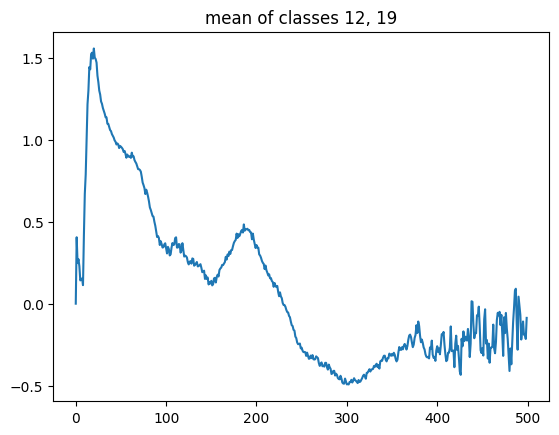

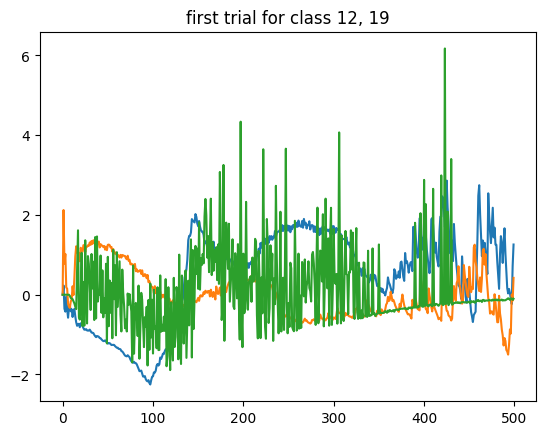

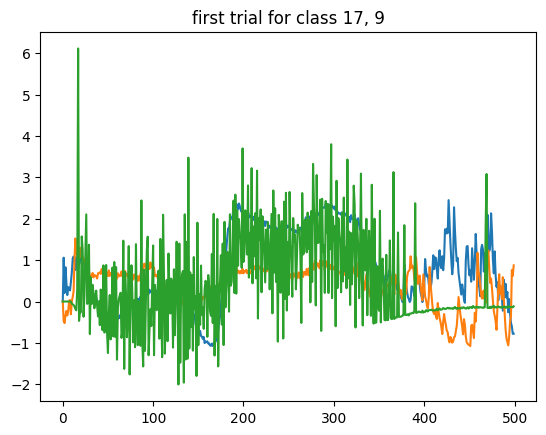

In [3]:
#dont want to process here - want to process when its in the big array
print(f'Total load time = {time.time() - total_load_time:.2f} seconds')

#-------formatting the trials into a single array for each class pair, of length n_samples * n_trials------------------
all_structure = {f'left_class_{class_left}': {f'right_class_{class_right}': [] for class_right in classes_right} for class_left in classes_left}

left_input_LFP_attleft_all = copy.deepcopy(all_structure)
right_input_LFP_attleft_all = copy.deepcopy(all_structure)
attention_LFP_attleft_all = copy.deepcopy(all_structure)

left_input_LFP_attright_all = copy.deepcopy(all_structure)
right_input_LFP_attright_all = copy.deepcopy(all_structure)
attention_LFP_attright_all = copy.deepcopy(all_structure)

for filenumber in file_numbers:
    for class_left in classes_left:
        for class_right in classes_right:
            left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attleft_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(left_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(right_input_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])
            attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'].extend(attention_LFP_attright_agg[f'dataset_{filenumber}'][f'left_class_{class_left}'][f'right_class_{class_right}'])

#------ want to preprocess each array here now that they are properly compiled ----------------
#looking first at the shape / structure of left_input_LFP_attleft_all:
left_attleft = copy.deepcopy(all_structure)
right_attleft = copy.deepcopy(all_structure)
att_attleft = copy.deepcopy(all_structure)

left_attright = copy.deepcopy(all_structure)
right_attright = copy.deepcopy(all_structure)
att_attright = copy.deepcopy(all_structure)



for class_left in classes_left:
        for class_right in classes_right:
            left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attleft_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

            left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(left_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(right_input_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])
            att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.vstack(attention_LFP_attright_all[f'left_class_{class_left}'][f'right_class_{class_right}'])

print('attention_input_LFP_attleft_all 01 raw =', attention_LFP_attleft_all[f'left_class_{0}'][f'right_class_{1}'])
print('checking 01:----------------------', att_attleft[f'left_class_{0}'][f'right_class_{1}'])

# for i in range(0, 3):
#     plt.plot(right_attleft[f'left_class_{12}'][f'right_class_{19}'][i])
#     plt.title('first trial for class 12, 19')
#     plt.show()


plt.plot(np.mean(right_attleft[f'left_class_{12}'][f'right_class_{19}'], axis=0))
plt.title('mean of classes 12, 19')
plt.show()

plt.plot(left_attleft[f'left_class_{12}'][f'right_class_{19}'][0])
plt.plot(right_attleft[f'left_class_{12}'][f'right_class_{19}'][0])
plt.plot(att_attleft[f'left_class_{12}'][f'right_class_{19}'][0])
plt.title('first trial for class 12, 19')   
plt.show()

plt.plot(left_attleft[f'left_class_{17}'][f'right_class_{9}'][0])
plt.plot(right_attleft[f'left_class_{17}'][f'right_class_{9}'][0])
plt.plot(att_attleft[f'left_class_{17}'][f'right_class_{9}'][0])
plt.title('first trial for class 17, 9')   
plt.show()




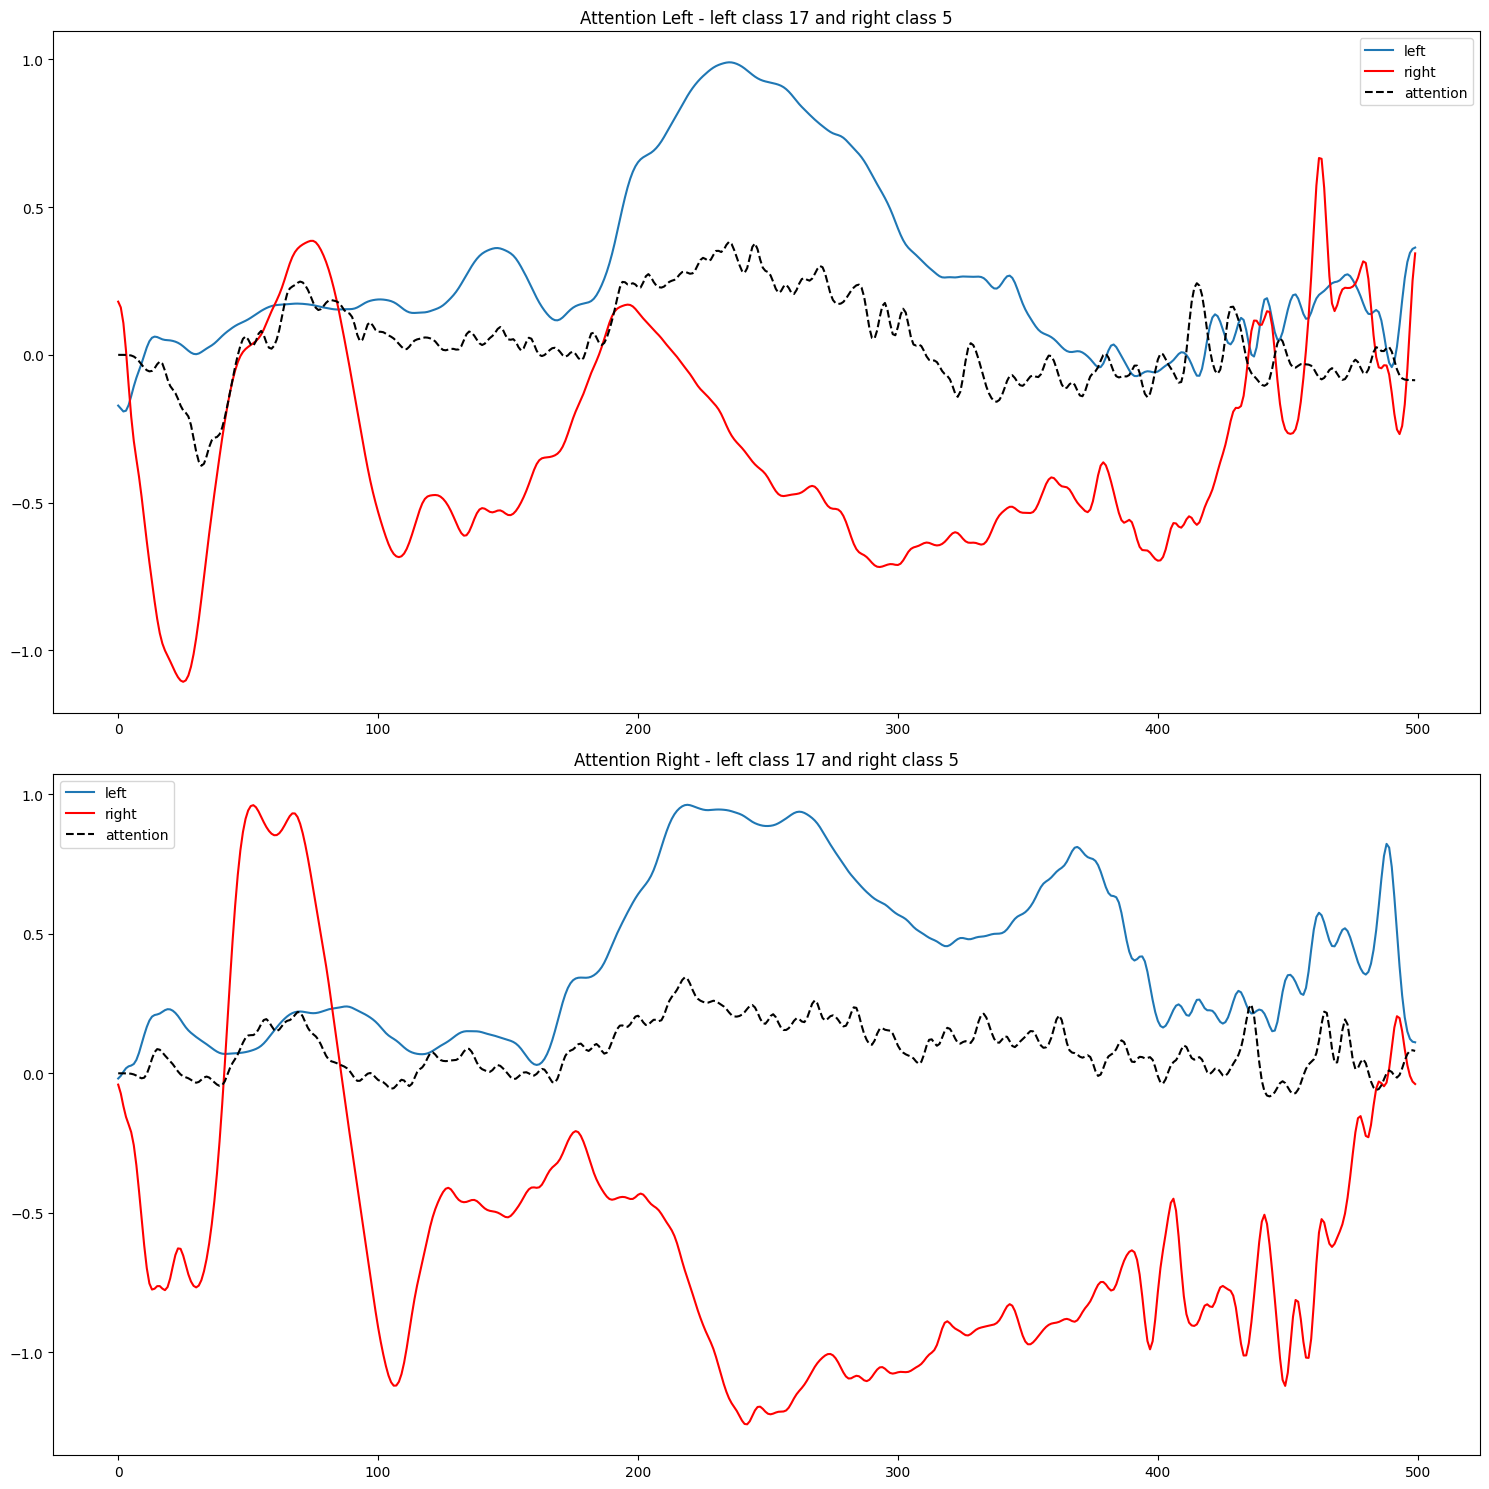

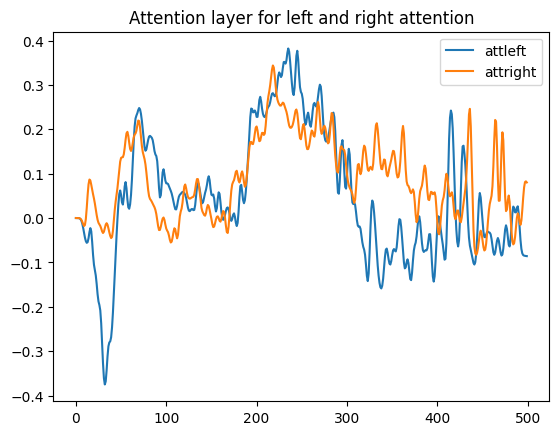

In [5]:
#no normean_left_attleft = copy.deepcopy(all_structure)
mean_left_attleft = copy.deepcopy(all_structure)
mean_right_attleft = copy.deepcopy(all_structure)
mean_attention_attleft = copy.deepcopy(all_structure)

mean_left_attright = copy.deepcopy(all_structure)
mean_right_attright = copy.deepcopy(all_structure)
mean_attention_attright = copy.deepcopy(all_structure)


#here take mean across all trials for each class pair
for class_left in classes_left:
    for class_right in classes_right:
        mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = np.mean(left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)

        mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)
        mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = np.mean(att_attright[f'left_class_{class_left}'][f'right_class_{class_right}'], axis = 0)


##will select a class pair and plot the traces 
class_left = 17
class_right = 5

def plot_class_pair():
    
    fig, ax = plt.subplots(2, figsize=(15, 15))

    ax[0].plot(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
    ax[0].plot(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right', color = 'r')
    ax[0].plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention', ls = '--', color = 'k')
    ax[0].set_title(f'Attention Left - left class {class_left} and right class {class_right}')
    ax[0].legend()

    ax[1].plot(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='left')
    ax[1].plot(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='right', color = 'r')
    ax[1].plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attention', ls = '--', color = 'k')
    ax[1].set_title(f'Attention Right - left class {class_left} and right class {class_right}')
    ax[1].legend()


    plt.tight_layout()
    plt.show()

    
#plot_class_pair()

#normalised
def norm(data):
    return data / np.max(data)


mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])

mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] = norm(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'])

#plot_class_pair()

#----------norm and smoothed---------------
from scipy.ndimage import gaussian_filter1d
def smooth_with_gaussian(data, sigma=2):
    return gaussian_filter1d(data, sigma=sigma) 

mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_left_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'])
mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_right_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] )

mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_left_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_right_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )
mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}']  = smooth_with_gaussian(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] )

plot_class_pair()


#also plotting the attention layers to if they differ substantially:

plt.plot(mean_attention_attleft[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attleft')
plt.plot(mean_attention_attright[f'left_class_{class_left}'][f'right_class_{class_right}'] , label='attright')
plt.title('Attention layer for left and right attention')
plt.legend()
plt.show()
